In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
print('Done!')

Done!


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
from tensorflow.io import read_file, decode_jpeg
from tensorflow.image import resize, ResizeMethod, random_crop, flip_left_right
from tensorflow.data import Dataset

The size of the image is (256, 512, 3)


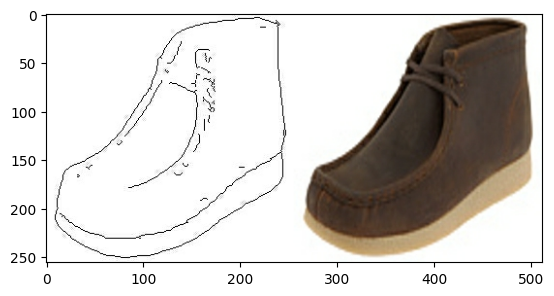

In [ ]:
img_path = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train/10006_AB.jpg"
sample_img = read_file(img_path)
sample_img = decode_jpeg(sample_img)
print(f"The size of the image is {sample_img.shape}")

plt.figure()
plt.imshow(sample_img)

(-0.5, 255.5, 255.5, -0.5)

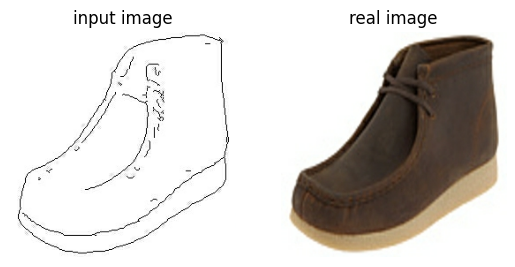

In [ ]:
def load(image_file):
    image = read_file(image_file)
    image = decode_jpeg(image)

    width = (tf.shape(image)[1]) // 2

    input_image, real_image = image[:, :width, :], image[:, width:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

input_img, real_img = load(img_path)

fig, axes = plt.subplots(1,2)
axes[0].imshow(input_img / 255.0)
axes[0].set_title('input image')
axes[0].axis('off')

axes[1].imshow(real_img / 255.0)
axes[1].set_title('real image')
axes[1].axis('off')

In [ ]:
def Resize(input_image, real_image):
    input_image = resize(input_image, [256,256], method= ResizeMethod.NEAREST_NEIGHBOR)
    real_image = resize(real_image, [256,256], method= ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image

In [ ]:
def RandomCrop(input_image, real_image, height=256, width=256):
    stached_image = tf.stack([input_image, real_image], axis=0)
    croped_image = random_crop(stached_image, size=[2, height, width, 3])

    return croped_image[0], croped_image[1]

In [ ]:
def Normalize(input_image, real_image, norm_size=127.5):
    input_image = (input_image / norm_size) - 1
    real_image = (real_image / norm_size) - 1

    return input_image, real_image

In [ ]:
def Random_Jitter(input_image, real_image):
    # Random cropping back to 256x256
    input_image, real_image = RandomCrop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
        # Random mirroring
        input_image = flip_left_right(input_image)
        real_image = flip_left_right(real_image)

    return input_image, real_image

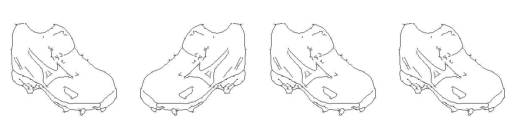

In [ ]:
input_img, real_img = load('/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train/10020_AB.jpg')

plt.figure()
for i in range(4):
    rj_input, rj_real = Random_Jitter(input_img, real_img)
    plt.subplot(1, 4, i + 1)
    plt.imshow(rj_input / 255.0)
    plt.axis('off')
plt.show()

In [ ]:
def load_train_images(file):
    input_image, real_image = load(file)
    input_image, real_image = Random_Jitter(input_image, real_image)
    input_image, real_image = Normalize(input_image, real_image, 127.5)
    return input_image, real_image

def load_test_images(file):
    input_image, real_image = load(file)
    input_image, real_image = Resize(input_image, real_image)
    input_image, real_image = Normalize(input_image, real_image, 127.5)
    return input_image, real_image

In [ ]:
path = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/"
train_data = Dataset.list_files(path + "train/*.jpg")
train_data = train_data.map(load_train_images).batch(1)

test_data = Dataset.list_files(path + "val/*.jpg")
test_data = test_data.map(load_test_images).batch(1)

In [ ]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Input, Concatenate
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
def DownSample(filters_number, filter_size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    downsample_model = Sequential()
    downsample_model.add(Conv2D(filters_number, filter_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        downsample_model.add(BatchNormalization())

    downsample_model.add(LeakyReLU())

    return downsample_model

down_model = DownSample(3, 4)
down_result = down_model(tf.expand_dims(input_img, 0))
print (down_result.shape)

(1, 128, 128, 3)


In [ ]:
def UpSample(filters_number, filter_size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    upsample_model = Sequential()
    upsample_model.add(Conv2DTranspose(filters_number, filter_size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    upsample_model.add(BatchNormalization())

    if apply_dropout == True:
        upsample_model.add(Dropout(0.5))

    upsample_model.add(ReLU())

    return upsample_model

up_model = UpSample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


In [ ]:
def Generator():
    downsample_stack = [
        DownSample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
        DownSample(128, 4),  # (batch_size, 64, 64, 128)
        DownSample(256, 4),  # (batch_size, 32, 32, 256)
        DownSample(512, 4),  # (batch_size, 16, 16, 512)
        DownSample(512, 4),  # (batch_size, 8, 8, 512)
        DownSample(512, 4),  # (batch_size, 4, 4, 512)
        DownSample(512, 4),  # (batch_size, 2, 2, 512)
        DownSample(512, 4),  # (batch_size, 1, 1, 512)
      ]

    upsmaple_stack = [
        UpSample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
        UpSample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
        UpSample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
        UpSample(512, 4),  # (batch_size, 16, 16, 1024)
        UpSample(256, 4),  # (batch_size, 32, 32, 512)
        UpSample(128, 4),  # (batch_size, 64, 64, 256)
        UpSample(64, 4),  # (batch_size, 128, 128, 128)
      ]

    inputs = Input(shape = [256,256,3])
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    X = inputs

    # Downsampling through the model
    skips = []
    for downsample in downsample_stack:
        X = downsample(X)
        skips.append(X)
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for upsample, skip in zip(upsmaple_stack, skips):
        X = upsample(X)
        X = Concatenate()([X, skip])
    X = last(X)

    return Model(inputs=inputs, outputs=X, name='Generator')

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128, 128,  │      3,072 │ input_layer_2[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 64, 64,    │    131,584 │ sequential_2[0][… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 32, 32,    │    525,312 │ sequential_3[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 16, 16,    │  2,099,200 │ sequential_4[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 8, 8, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 4, 4, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 1, 1, 512) │  4,196,352 │ sequential_8[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 2, 2, 512) │  4,196,352 │ sequential_9[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_11[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_12[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_13[0]

 Total params: 54,425,859 (207.62 MB)

 Trainable params: 54,414,979 (207.58 MB)

 Non-trainable params: 10,880 (42.50 KB)

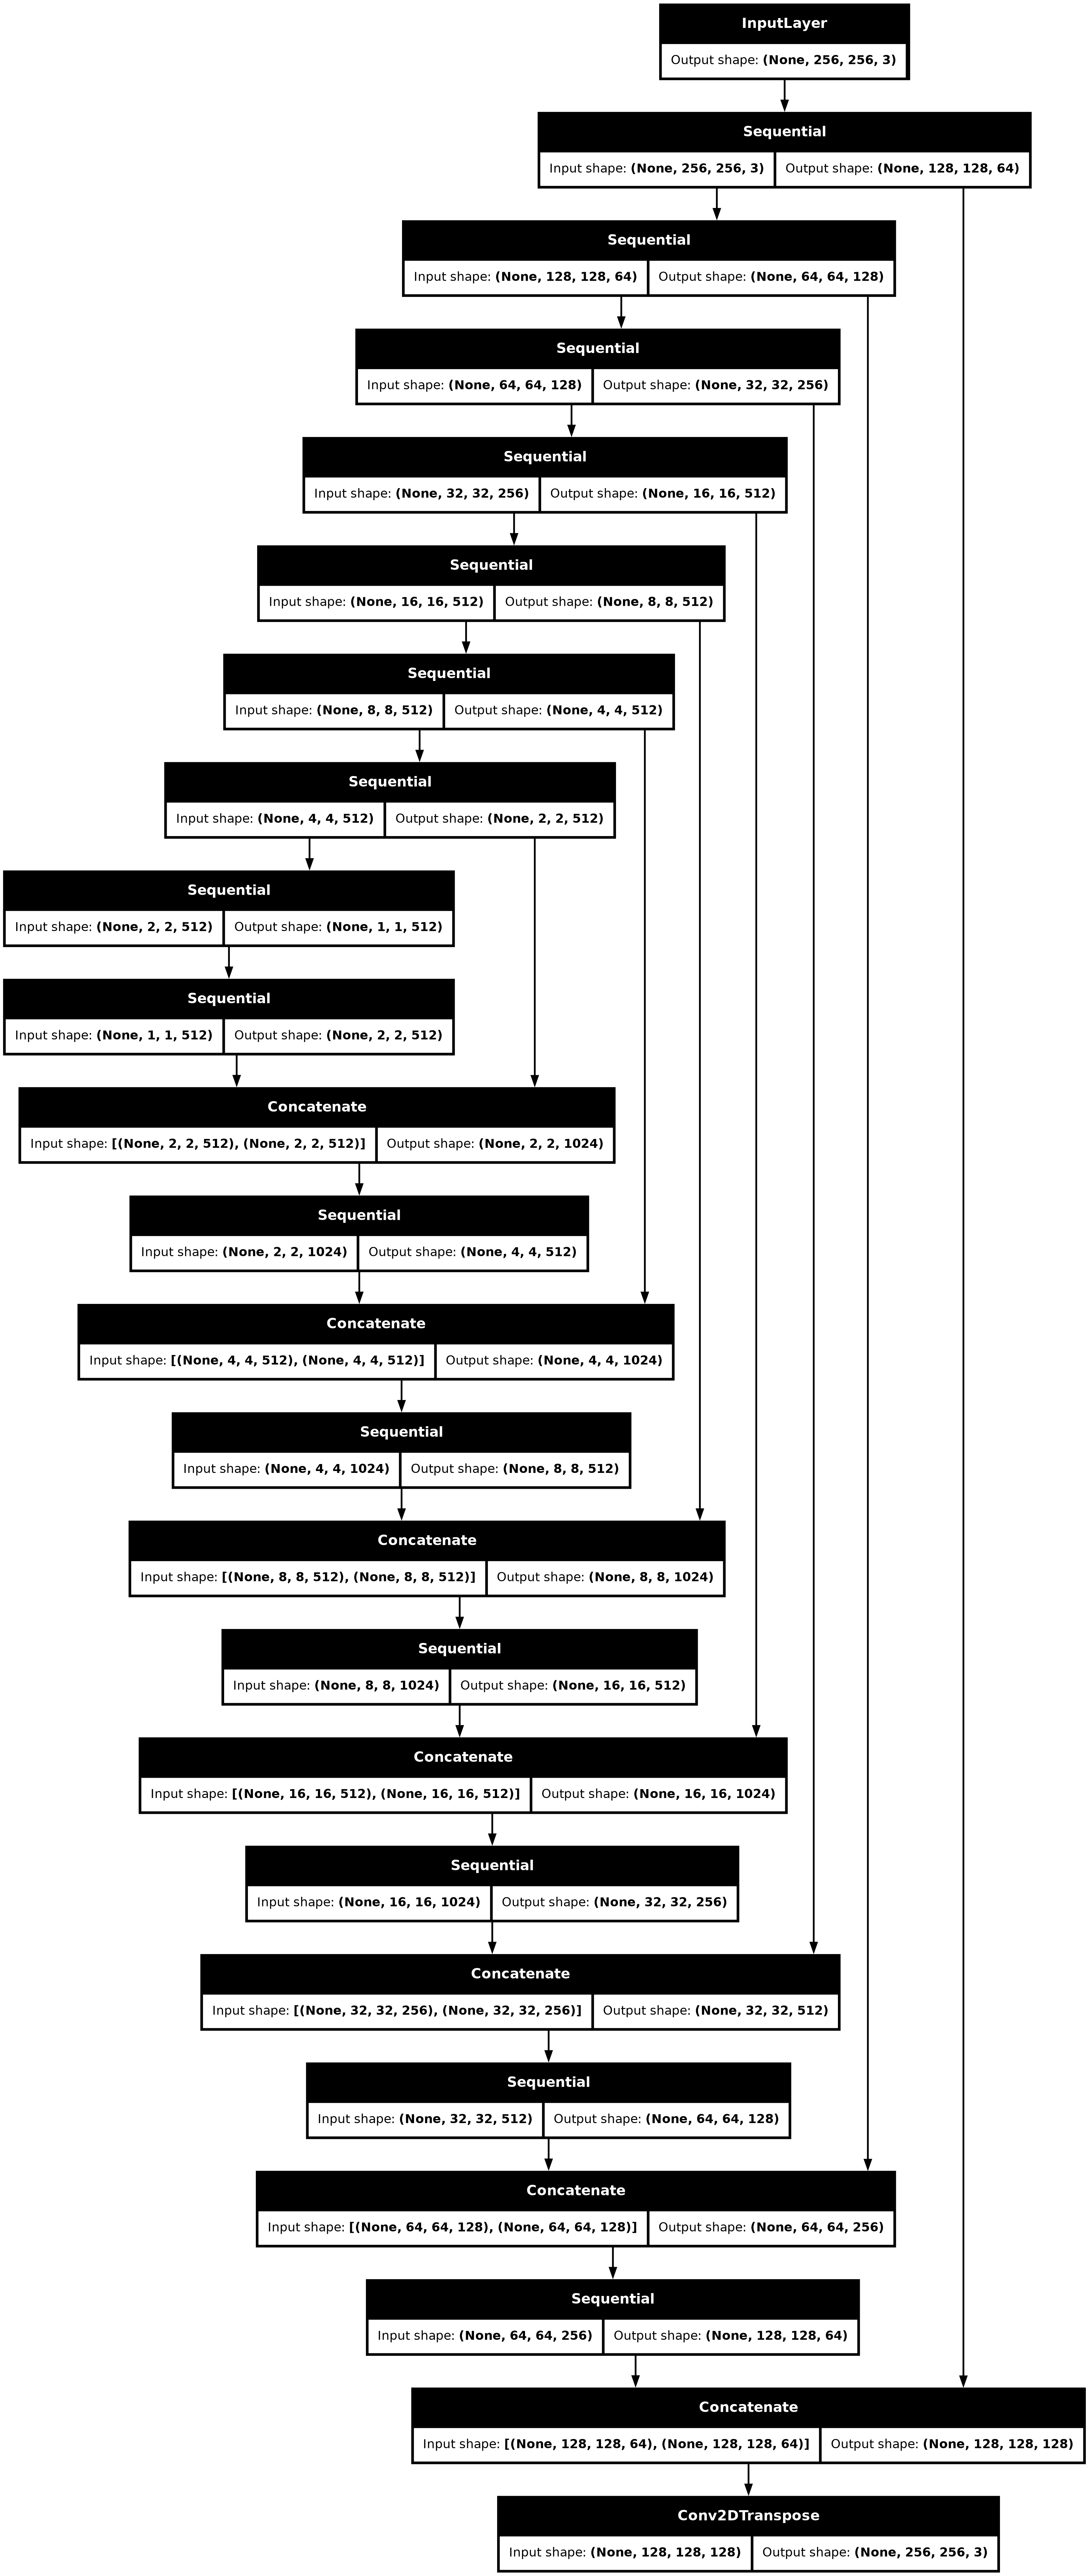

In [ ]:
generator = Generator()
generator.summary()
plot_model(generator, show_shapes=True)

In [ ]:
from tensorflow.keras.layers import ZeroPadding2D, concatenate

def Discriminator():
    initializer = tf.random_normal_initializer(0.,0.02)

    input_image = Input(shape=[256,256,3], name='input_image')
    target_image = Input(shape=[256,256,3], name='target_image')

    X = concatenate([input_image, target_image])

    downsample1 = DownSample(64, 4, False)(X)
    downsample2 = DownSample(128, 4)(downsample1)
    downsample3 = DownSample(256, 4)(downsample2)

    zero_pad1 = ZeroPadding2D()(downsample3)
    conv = Conv2D(256, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)

    batch_norm1 = BatchNormalization()(conv)

    leaky_relu = LeakyReLU()(batch_norm1)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    y = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)

    return Model(inputs=[input_image,target_image], outputs=y, name='Discriminator')

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 6)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_17       │ (None, 128, 128,  │      6,144 │ concatenate_7[0]… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_18       │ (None, 64, 64,    │    131,584 │ sequential_17[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_19       │ (None, 32, 32,    │    525,312 │ sequential_18[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_19[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 31, 31,    │  1,048,576 │ zero_padding2d[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      1,024 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_12      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_12[0… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 30, 30, 1) │      4,097 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,716,737 (6.55 MB)

 Trainable params: 1,715,457 (6.54 MB)

 Non-trainable params: 1,280 (5.00 KB)

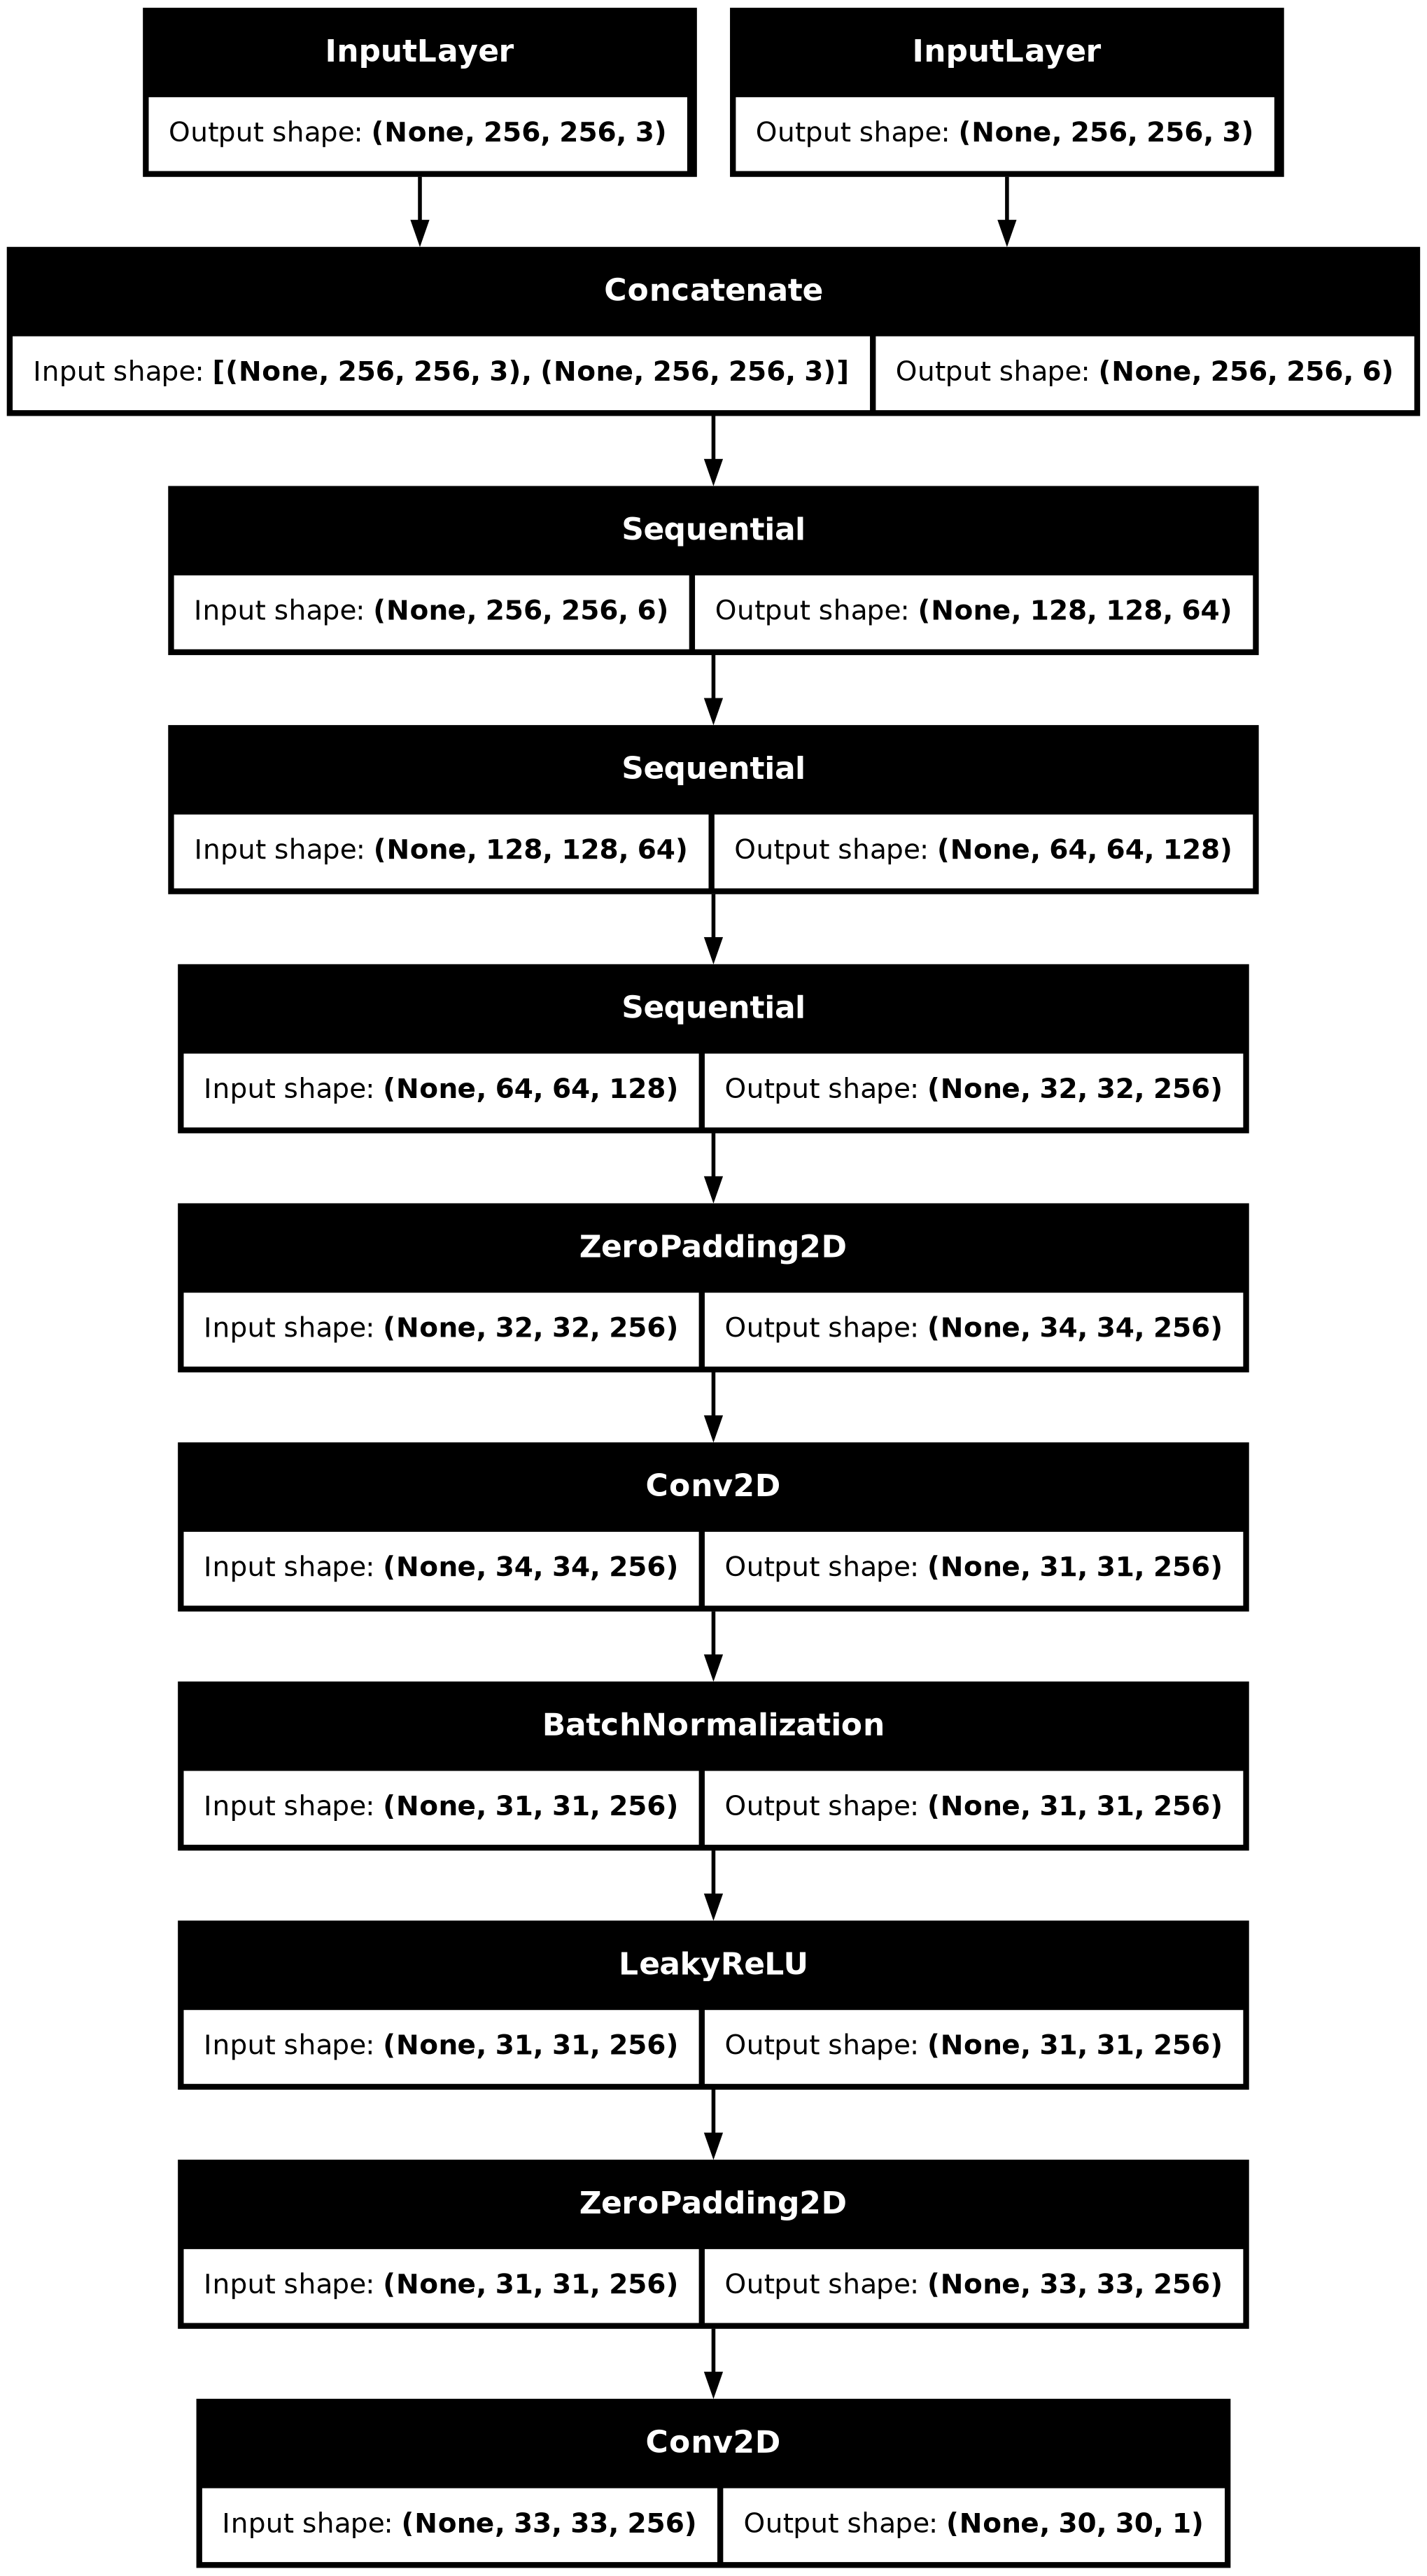

In [ ]:
discriminator = Discriminator()
discriminator.summary()
plot_model(discriminator, show_shapes=True)

In [ ]:
Lambda = 100
loss = BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
    GAN_loss = loss(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_generator_loss = GAN_loss + (Lambda * l1_loss)
    return total_generator_loss, GAN_loss, l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_discriminator_loss = real_loss + generated_loss
    return total_discriminator_loss

In [ ]:
from tensorflow.keras.optimizers import Adam

generator_optimizer = Adam(2e-4, beta_1=0.5)
discriminator_optimizer = Adam(2e-4, beta_1=0.5)

In [ ]:
def save_images(model, test_input, target, epoch):
    prediction = model(test_input, training= True)
    plt.figure()
    display_list= [test_input[0], target[0], prediction[0]]
    title = ["Input Image", "Ground Truth", "Predicton Image"]
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis("off")
    plt.savefig(f"output/epoch_{epoch}.jpg")
    plt.close()

In [ ]:
# make sure output directory exists to save images
if not os.path.exists("output"):
    os.mkdir("output")

In [ ]:
@tf.function
def train_step(input_image, target, epoch):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training = True)

        disc_real_output = discriminator([input_image, target], training = True)
        disc_generated_output = discriminator([input_image, gen_output], training = True)

        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

        generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
        discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

        return gen_total_loss, disc_loss

In [ ]:
def Fit(train_ds, epochs, test_ds):
    for epoch in range(epochs):
        start = time.time()

        for input_, target in test_ds.take(1):
            save_images(generator, input_, target, epoch)

        # Train
        print(f"Epoch {epoch}")
        for n, (input_, target) in train_ds.enumerate():
            gen_loss, disc_loss = train_step(input_, target, epoch)
        print("Generator loss {:.2f} Discriminator loss {:.2f}".format(gen_loss, disc_loss))
        print("Time take for epoch {} is {:.2f} sec\n".format(epoch, time.time() - start))

In [ ]:
os.environ['TF_DISABLE_MKL'] = '1'
epochs=100
Fit(train_data, epochs, test_data)

Epoch 0
